## Subcategory SVM

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from  sklearn import svm as sksvm
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.svm
from sklearn.metrics import f1_score, recall_score, precision_score
from itertools import product
import numpy as np
import datasets
import joblib
import dotenv
import json
import os


In [2]:
dotenv.load_dotenv()
HF_TOKEN = os.environ['HF_TOKEN']
DATASET_LINK = os.environ['DATASET_LINK']
SEED = 42
TRAINING = True
datasetTotal = datasets.load_dataset(DATASET_LINK, token=HF_TOKEN)

In [3]:
valSet = pd.DataFrame(datasetTotal['validation'])[['subcategory', 'label', 'category','type']]
trainSet = pd.DataFrame(datasetTotal['train'])[['subcategory', 'label', 'category', 'type']]

In [4]:
subcatTrain = set(trainSet['subcategory'])
subcatVal = set(valSet['subcategory'])

subcat = subcatTrain.union(subcatVal)
print(len(subcat))
aliasesSub = {k:i for i,k in enumerate(subcat)}
print(aliasesSub)

catTrain = set(trainSet['category'])
catVal = set(valSet['category'])

cat = catTrain.union(catVal)
print(len(cat))

aliasesCat = {k:i for i,k in enumerate(cat)}
print(aliasesCat)

typeTrain = set(trainSet['type'])
typeVal = set(valSet['type'])

typeTot = typeTrain.union(typeVal)
aliasesType = {k:i for i,k in enumerate(typeTot)}
print(len(typeTot))
print(aliasesType)
aliasLabel = {
    'cultural exclusive':0,
    'cultural agnostic':1,
    'cultural representative':2
}


112
{'film producer': 0, 'construction': 1, 'music festival': 2, 'theatrical director': 3, 'archive': 4, 'dance': 5, 'biologist': 6, 'historical event': 7, 'manga': 8, 'sport': 9, 'dish': 10, 'ingredient': 11, 'government': 12, 'building': 13, 'mode of transport': 14, 'animated film': 15, 'station': 16, 'geographic location': 17, 'river': 18, 'model': 19, 'transport company': 20, 'mountain': 21, 'record label': 22, 'animal': 23, 'gesture': 24, 'cook': 25, 'television': 26, 'politician': 27, 'streaming service': 28, 'painting': 29, 'musician': 30, 'recurring sporting event': 31, 'religious movement': 32, 'body language': 33, 'magazine': 34, 'art gallery': 35, 'animation studio': 36, 'religion': 37, 'musical group': 38, 'sports club': 39, 'comics artist': 40, 'philosophy': 41, 'sports equipment': 42, 'food': 43, 'athlete': 44, 'designer': 45, 'non-fiction writer': 46, 'film': 47, 'architectural structure': 48, 'writer': 49, 'plant': 50, 'film studio': 51, 'publisher': 52, 'choreographer'

In [ ]:
# Backup the encodings
if False:
    aliasesList = [aliasesCat, aliasesSub, aliasesType, aliasLabel]
    for n,i in enumerate(['categories', 'subcategories', 'types', 'labels']):
        with open(f'{i}Aliases.json', 'w+') as file:
            json.dump(aliasesList[n], file)

In [5]:
subCategoryEncodingTrain = np.zeros((trainSet.shape[0], len(subcat)), dtype=int)
categoryEncodingTrain = np.zeros((trainSet.shape[0], len(cat)), dtype=int)
typeEncodingTrain = np.zeros((trainSet.shape[0], len(typeTot)), dtype=int)

finalTrainLabel = trainSet['label'].apply(lambda x: aliasLabel[x])

for i in range(trainSet.shape[0]):
    subCategoryEncodingTrain[i][aliasesSub[trainSet['subcategory'].iloc[i]]] = 1
    categoryEncodingTrain[i][aliasesCat[trainSet['category'].iloc[i]]] = 1
    typeEncodingTrain[i][aliasesType[trainSet['type'].iloc[i]]] = 1
    
finalTrainData = np.concatenate((subCategoryEncodingTrain, categoryEncodingTrain, typeEncodingTrain), axis=1)
print(finalTrainData.shape)

(6251, 133)


In [6]:
subCategoryEncodingVal = np.zeros((valSet.shape[0], len(subcat)), dtype=int)
categoryEncodingVal = np.zeros((valSet.shape[0], len(cat)), dtype=int)
typeEncodingVal = np.zeros((valSet.shape[0], len(typeTot)), dtype=int)

finalValLabel = valSet['label'].apply(lambda x: aliasLabel[x])

for i in range(valSet.shape[0]):
    try:
        subCategoryEncodingVal[i][aliasesSub[valSet['subcategory'].iloc[i]]] = 1
    except KeyError as e:
        pass
    try:
        categoryEncodingVal[i][aliasesCat[valSet['category'].iloc[i]]] = 1
    except KeyError as e:
        pass
    try:
        typeEncodingVal[i][aliasesType[valSet['type'].iloc[i]]] = 1
    except KeyError as e:
        pass
finalValData = np.concatenate((subCategoryEncodingVal, categoryEncodingVal, typeEncodingVal), axis=1)
print(finalValData.shape)

(300, 133)


In [37]:
def trainPass(scale: float, 
              gamma: float, 
              kernel: str, 
              features: np.ndarray, 
              labels: np.ndarray, 
              validation_features: np.ndarray, 
              validation_labels: np.ndarray
              )->tuple[float, sklearn.svm.SVC]:
    modelSubcategory = sksvm.SVC(kernel=kernel, 
                                C=scale, 
                                gamma=gamma,
                                class_weight={0: 0.7743094264833396, 1: 1.1130698005698005, 2: 1.2343996840442337}, 
                                probability=True, 
                                random_state=SEED,
                                max_iter=10000)
    modelSubcategory.fit(features, labels)
    accuracy_score = modelSubcategory.score(validation_features, validation_labels)
    return accuracy_score, modelSubcategory

In [39]:

bestScore = 0
bestModel = None

TRAINING = 1

if TRAINING == 2:
    gammaCandidates = np.linspace(0.1,1,10)
    cCandidates = np.linspace(1,10,10)
    kernels = ['rbf', 'linear']
    for g,c,k in tqdm(product(gammaCandidates, cCandidates, kernels)):
        score, model =  trainPass(c,g,k,
                                    finalTrainData,
                                    finalTrainLabel,
                                    finalValData,
                                    finalValLabel)
        if score > bestScore:
            bestModel = model
            bestScore = score
            params = {'c':c, 'gamma':g}
    print(bestModel)
    print(f"Accuracy: {bestScore*100:.4f}%")
    
elif TRAINING == 1:
    c = 4.0
    gamma = 0.1
    k = 'linear'
    score, model =  trainPass(c,gamma,k,
                                    finalTrainData,
                                    finalTrainLabel,
                                    finalValData,
                                    finalValLabel)
    print(model)
    print(f"Accuracy: {score*100:.4f}%")




# score, bestModel = trainPass(10,1,'rbf',
#                                  finalTrainData,
#                                  finalTrainLabel,
#                                  finalValData,
#                                  finalValLabel)          

SVC(C=4.0,
    class_weight={0: 0.7743094264833396, 1: 1.1130698005698005,
                  2: 1.2343996840442337},
    gamma=0.1, kernel='linear', max_iter=10000, probability=True,
    random_state=42)
Accuracy: 64.0000%


In [ ]:
# {'k': 'rbf', 'c': 4.0, 'g': 0.1}

In [32]:
print(f"F1 Score: {f1_score(bestModel.predict(finalValData), finalValLabel,average='weighted')}")
print(f"Recall: {recall_score(bestModel.predict(finalValData), finalValLabel, average='weighted')}")
print(f"Precision: {precision_score(bestModel.predict(finalValData), finalValLabel, average='weighted')}")

F1 Score: 0.677557436338669
Recall: 0.6666666666666666
Precision: 0.7005823148813802


In [10]:
if TRAINING:
    joblib.dump(bestModel, 'categorySVCWeights.pkl')

In [21]:
svm = bestModel
    
results = svm.predict_proba(finalValData)
confidence = results[np.arange(results.shape[0]), np.argmax(results, axis=1)]*100

print(f'Max confidence: {confidence.max():.4f}%')
print(f'Min confidence: {confidence.min():.4f}%')
print(f'Mean confidence: {confidence.mean():.4f}%')
print(f'Std confidence: {confidence.std():.4f}%')

Max confidence: 77.1424%
Min confidence: 35.3201%
Mean confidence: 63.8154%
Std confidence: 8.8505%


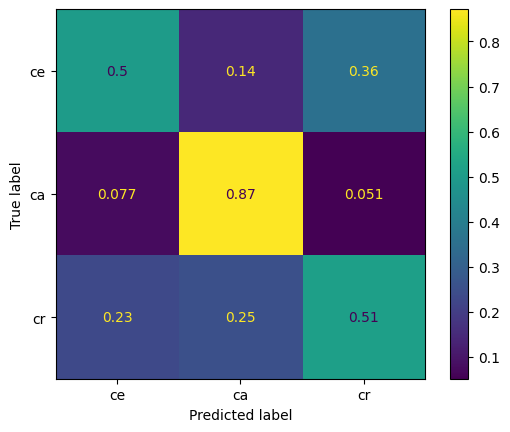

In [25]:
predictions = svm.predict(finalValData)

cfm = confusion_matrix(y_true=finalValLabel, y_pred=predictions, labels=[0,1,2], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=['ce', 'ca', 'cr'])
disp.plot()
plt.show()

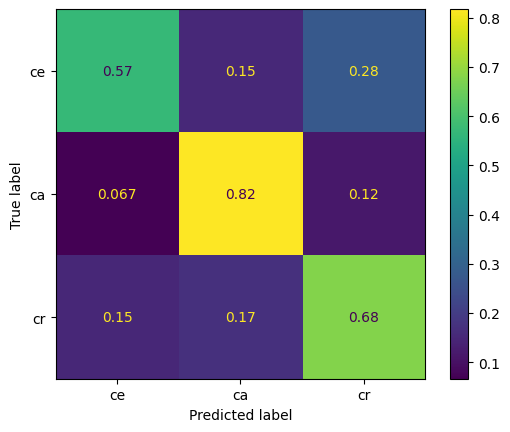

In [26]:
predictions = svm.predict(finalTrainData)

cfm = confusion_matrix(y_true=finalTrainLabel, y_pred=predictions, labels=[0,1,2], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=['ce', 'ca', 'cr'])
disp.plot()
plt.show()